<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Classification_NO_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=13, stratify=y_train_big, random_state=2)                                                         

#Z score dei dati

In [0]:
mean = X_train_1.mean(axis=0)
train_data_stand = X_train - mean
std = X_train.std(axis=0)
train_data_stand /= std

In [0]:
val_data_stand = X_val - mean
val_data_stand /= std

In [0]:
test_data_stand = X_test - mean
test_data_stand /= std

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [37]:
train_data_stand_lda = lda.fit(train_data_stand, y_train).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [38]:
train_data_stand_lda.shape

(105, 2)

In [0]:
val_data_stand_lda = lda.transform(val_data_stand)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

#Z-score dopo LDA

In [0]:
mean = train_data_stand_lda.mean(axis=0)
std = train_data_stand_lda.std(axis=0)
train_data_stand_lda = train_data_stand_lda - mean
train_data_stand_lda /= std

In [0]:
val_data_stand_lda = val_data_stand_lda - mean
val_data_stand_lda /= std

In [0]:
test_data_stand_lda = test_data_stand_lda - mean
test_data_stand_lda /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('loss', patience=10, verbose=1, min_lr=0.0001)

In [62]:
one_hot_val_labels.shape

(105, 3)

In [64]:
num_epochs = 180

model = build_model()
history = model.fit(train_data_stand_lda, one_hot_train_labels, validation_data=(val_data_stand_lda, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=1)
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 105 samples, validate on 13 samples
Epoch 1/180




105/105 [==============================] - 0s 3ms/step - loss: 0.7584 - acc: 0.9048 - val_loss: 1.5579 - val_acc: 0.2308
Epoch 2/180
105/105 [==============================] - 0s 1ms/step - loss: 0.6654 - acc: 0.9905 - val_loss: 1.4746 - val_acc: 0.2308
Epoch 3/180
105/105 [==============================] - 0s 1ms/step - loss: 0.5914 - acc: 1.0000 - val_loss: 1.4319 - val_acc: 0.3077
Epoch 4/180
105/105 [==============================] - 0s 1ms/step - loss: 0.5283 - acc: 1.0000 - val_loss: 1.4250 - val_acc: 0.3846
Epoch 5/180
105/105 [==============================] - 0s 965us/step - loss: 0.4720 - acc: 1.0000 - val_loss: 1.4396 - val_acc: 0.4615
Epoch 6/180
105/105 [==============================] - 0s 974us/step - loss: 0.4212 - acc: 1.0000 - val_loss: 1.4766 - val_acc: 0.4615
Epoch 7/180
105/105 [==============================] 

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

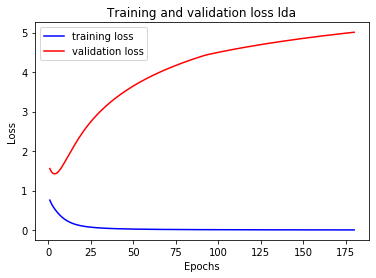

In [67]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

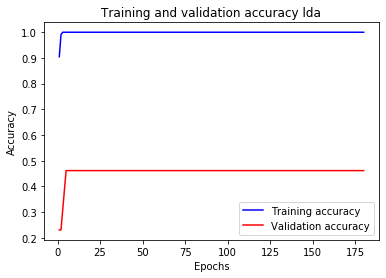

In [68]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [71]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=1, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/180
105/105 [==============================] - 0s 3ms/step - loss: 0.9294 - acc: 0.4952
Epoch 2/180
105/105 [==============================] - 0s 921us/step - loss: 0.8590 - acc: 0.4762
Epoch 3/180
105/105 [==============================] - 0s 889us/step - loss: 0.8044 - acc: 0.4762
Epoch 4/180
105/105 [==============================] - 0s 1ms/step - loss: 0.7607 - acc: 0.4952
Epoch 5/180
105/105 [==============================] - 0s 1ms/step - loss: 0.7243 - acc: 0.5143
Epoch 6/180
105/105 [==============================] - 0s 961us/step - loss: 0.6932 - acc: 0.5524
Epoch 7/180
105/105 [==============================] - 0s 952us/step - loss: 0.6658 - acc: 0.6476
Epoch 8/180
105/105 [==============================] - 0s 920us/step - loss: 0.6414 - acc: 0.7524
Epoch 9/180
105/105 [==============================] - 0s 990us/step - loss: 0.6194 - acc: 0.7905
Epoch 10/180
105/105 [==============================] - 0s 951us/step - loss: 0.5993 - acc: 0.8571
Epoch 11/180
105/105 [===

In [72]:
model.metrics_names

['loss', 'acc']

In [73]:
test_acc


0.4615384638309479

Si comporta molto bene in training e in validation ma si comporta male in test

Remove correlated features manually